# Data Source
* [Famine](https://web.archive.org/web/20170802193952/http://fletcher.tufts.edu/World-Peace-Foundation/Program/Research/Mass-Atrocities-Research-Program/Mass-Famine#Dataset)

I came across this data from the [World in Data Famine Post](https://ourworldindata.org/famines). 

# Data Preparation

In [1]:
# Get all necessary packages
import pandas as pd
import os
import scipy.stats as stats
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# Read in and check file
famine = pd.read_csv("data" + os.sep + "famine" + os.sep + "famine.csv", sep = ",")
#famine.head()

In [3]:
# Calculate duration 
# Add one to avoid duration of 0
famine["Duration"] = (famine["End Year"]+1) - famine["Start Year"]
#famine.head()

I decided to not work with the total death count of the famines, but instead calculate how many people died per year the famine persisted. This makes them more easily comparable. 

In [4]:
# Calculate death per year
famine["Death per Year"] = famine["Mean Death"] / famine["Duration"]
#famine.head()

Text(0.5, 0, 'Death per year')

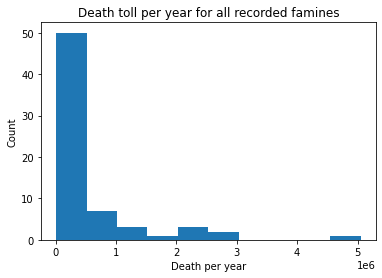

In [5]:
# Plot death per year
ax = famine["Death per Year"].sort_values(ascending=False).plot(kind="hist", bins= 10)
ax.set_title("Death toll per year for all recorded famines")
ax.set_ylabel("Count")
ax.set_xlabel("Death per year")

# Prepare for histogram fitting

I first tried to do this via fitting to a histogram, as Morgan proposed. However, I am not so sure if this is a good way to do it. Making a histogram means binning the data and if possible you should always do your analysis on unbinned data. Also, the break is quite hard if we use it that way, which results in worse fits. 

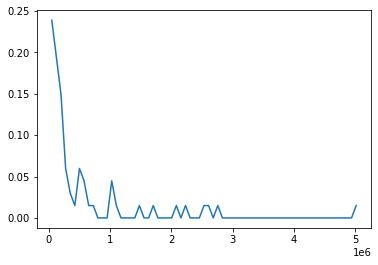

In [6]:
# Bin the data
density, death_per_year = np.histogram(famine["Death per Year"], bins = len(famine.index), density=True)
# adjust the denisty to the bin width (https://stackoverflow.com/questions/21532667/numpy-histogram-cumulative-density-does-not-sum-to-1)
density = density*np.diff(death_per_year)
# calculate the bin means
death_per_year = np.array([0.5 * (death_per_year[i] + death_per_year[i+1]) for i in range(len(death_per_year)-1)])
# plot
plt.plot(death_per_year, density)

# Histogram fit to Power Law
As the histogram data is so rough, we can get a fit, but not a great one. 

In [7]:
# Fit data to power law
def powerlaw(x,exponent):
    return (x**exponent)/np.min(x)**exponent
params, covar = curve_fit(powerlaw, death_per_year, density)
params

array([-1.57879647])

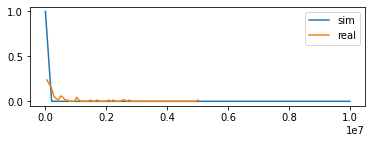

In [8]:
# Plot the power law
x_sim = np.linspace(1,10000000)
y_sim = powerlaw(x_sim, params[0])
fig = plt.figure()
ax = fig.add_subplot(2, 1, 1)
ax.plot(x_sim, y_sim,label="sim")
ax.plot(death_per_year, density, label="real")
ax.legend()
#ax.set_yscale("log")
#ax.set_xscale("log")

# Histogram fit to lognormal
Lognormal is even worse, so I would recommend sticking to the powerlaw. 

In [9]:
# Fit data to lognormal
def lognormal(x,upsilon,epsilon):
    numerator=np.exp(-np.power((np.log(x)-upsilon),2)/(2*epsilon**2))
    denominator=x*np.sqrt(2*np.pi*epsilon**2)
    return numerator/denominator
params, covar = curve_fit(lognormal, death_per_year, density)
params

array([1., 1.])

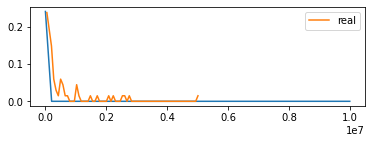

In [10]:
# Plot the lognormal
x_sim = np.linspace(1,10000000)
y_sim = lognormal(x_sim, params[0], params[1])
fig = plt.figure()
ax = fig.add_subplot(2, 1, 1)
ax.plot(x_sim, y_sim)
ax.plot(death_per_year, density, label="real")
ax.legend()
#ax.set_xscale("log")
#ax.set_yscale("log")

# Cumulative distribution fitting 
Looking at the cumulative distribution allows us to use all the data, without introducing arbitrary bins like when we use a histogram. To get the Frequency of all events we simply take the cumulative sum of the total time we looked at. 

Morgan also said I should try implementing [this fitting](https://scipy-cookbook.readthedocs.io/items/FittingData.html) from the scipy cookbook to avoid a fit that goes below 0. However, I didn't manage to get it running in the time I had. But I am also not sure how viable this code is for this, as the data it is fitted on is generated with a power law that does not go below zero. Therefore, the resulting fit naturally goes not below 0 as well.

In [11]:
# Sort for further calculations with cumsum
famine=famine.sort_values("Death per Year",ascending=False)

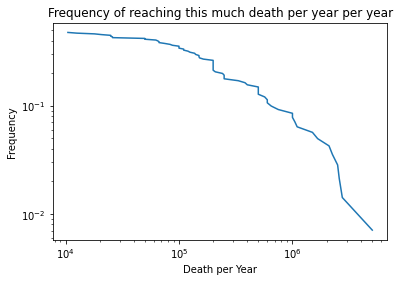

In [12]:
# Calculate the Frequency in a year with a given famine
# Does it make more sense to take the whole timeline with 141 or just the years with famine?
years_with_famine = 141
famine["time"] = 1/years_with_famine
famine["Frequency"] = np.cumsum(famine["time"])
# Plot
fig = plt.Figure()
plt.plot(famine["Death per Year"], famine["Frequency"])
ax = plt.gca()
ax.set_xlabel("Death per Year")
ax.set_ylabel("Frequency")
ax.set_title("Frequency of reaching this much death per year per year")
ax.set_yscale("log")
ax.set_xscale("log")

Does not seem like a real power law, but relatively close. 

## Fitting with power law

In [13]:
# Fit data to power law
def func_powerlaw(x, m, c):
    return x**m * c
params, covar = curve_fit(func_powerlaw, famine["Death per Year"], famine["Frequency"], maxfev=100000)
params

array([-0.33526421, 13.52172298])

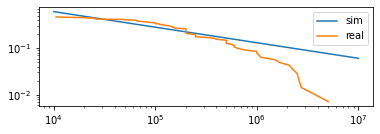

In [14]:
# Plot the power law
x_sim = np.linspace(10000,10000000)
y_sim = func_powerlaw(x_sim, params[0], params[1])
fig = plt.figure()
ax = fig.add_subplot(2, 1, 1)
ax.plot(x_sim, y_sim, label="sim")
ax.plot(famine["Death per Year"], famine["Frequency"], label="real")
ax.legend()
ax.set_xscale("log")
ax.set_yscale("log")

However, when we include a constant c0, we get a better fit, but we also predict frequencies below 0, which does not make much sense. 

In [15]:
# Fit data to power law
def func_powerlaw(x, m, c, c0):
    return c0 + x**m * c
params, covar = curve_fit(func_powerlaw, famine["Death per Year"], famine["Frequency"], maxfev=100000)

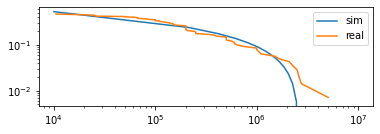

In [16]:
# Plot the power law
x_sim = np.linspace(10000,10000000)
y_sim = func_powerlaw(x_sim, params[0], params[1], params[2])
fig = plt.figure()
ax = fig.add_subplot(2, 1, 1)
ax.plot(x_sim, y_sim, label="sim")
ax.plot(famine["Death per Year"], famine["Frequency"], label="real")
#ax.set_ylim([0,1])
ax.legend()
ax.set_xscale("log")
ax.set_yscale("log")

## Fitting with lognormal

/home/florian/local/anaconda3/lib/python3.9/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


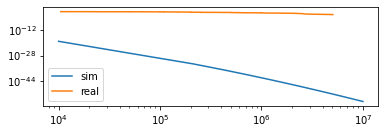

In [17]:
# Fit data to lognormal
def lognormal(x,upsilon,epsilon):
    numerator=np.exp(-np.power((np.log(x)-upsilon),2)/(2*epsilon**2))
    denominator=x*np.sqrt(2*np.pi*epsilon**2)
    return numerator/denominator
params, covar = curve_fit(lognormal, famine["Death per Year"], famine["Frequency"], maxfev=1000000)
# Plot 
x_sim = np.linspace(10000,10000000)
y_sim = lognormal(x_sim, params[0], params[1])
fig = plt.figure()
ax = fig.add_subplot(2, 1, 1)
ax.plot(x_sim, y_sim, label="sim")
ax.plot(famine["Death per Year"], famine["Frequency"], label="real")
ax.legend()
ax.set_xscale("log")
ax.set_yscale("log")

## Fitting with exponential decay

/home/florian/local/anaconda3/lib/python3.9/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


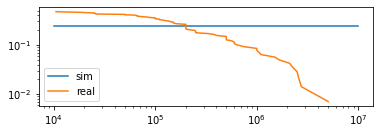

In [18]:
def monoExp(x, m, t, b):
    return m * np.exp(-t * x) + b
params, covar = curve_fit(monoExp, famine["Death per Year"], famine["Frequency"], maxfev=1000000)
# Plot 
x_sim = np.linspace(10000,10000000)
y_sim = monoExp(x_sim, params[0], params[1], params[2])
fig = plt.figure()
ax = fig.add_subplot(2, 1, 1)
ax.plot(x_sim, y_sim, label="sim")
ax.plot(famine["Death per Year"], famine["Frequency"], label="real")
ax.legend()
ax.set_xscale("log")
ax.set_yscale("log")